## Trait-management performance
Quantifying performance of different trait combinations in terms of __yield__ & __yield variance__

In [1]:
import collections

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from palettable.colorbrewer.sequential import YlGn_9
from palettable.colorbrewer.sequential import YlGnBu_9
from palettable.colorbrewer.sequential import BuGn_6

from palettable.cmocean.sequential import Tempo_10
from palettable.colorbrewer.qualitative import Set2_5
from palettable.colorbrewer.sequential import PuRd_8
from palettable.colorbrewer.diverging import PuOr_6
from palettable.colorbrewer.diverging import PuOr_7
from palettable.colorbrewer.sequential import YlGn_8
from palettable.cartocolors.sequential import PurpOr_6
from palettable.cartocolors.qualitative import Vivid_5

from ideotype.data_process import read_sims, read_data, parse_mature, agg_sims, process_sims
from ideotype.analysis import (identify_top_phenos,
                               top_pheno_prevalence,
                               prevalent_top_pheno,
                               rank_all_phenos,
                               phenostage_climate)
from ideotype.utils import custom_colormap, fold
from ideotype.init_params import params_sample

In [2]:
df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(
    '/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths_present.yml')
df_extended, df_stuck = parse_mature(df_all)

### High performing trait-management combination for each site

Text(0.5, 1.0, 'Yield mean and disparsion - averaged over all sites')

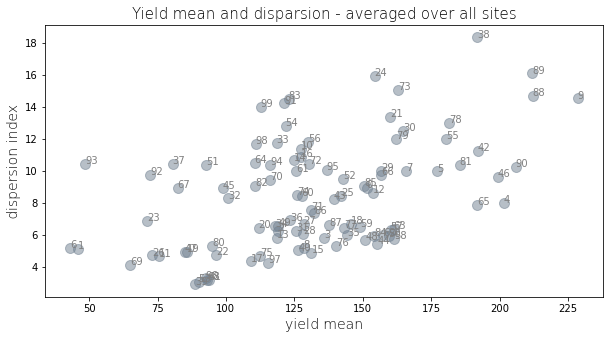

In [3]:
# yield variance across site & years
yield_mean = df_all.groupby('cvar').mean().dm_ear
yield_variance = df_all.groupby('cvar').var().dm_ear
yield_disp = yield_variance/yield_mean

# visulization
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
sc = ax.scatter(yield_mean, yield_variance/yield_mean, c='slategrey', s=100, alpha=0.5)
for i in np.arange(100):
    ax.annotate(i, (yield_mean[i], yield_variance[i]/yield_mean[i]), c='grey')
    
ax.set_xlabel('yield mean', fontweight='light', size=14)
ax.set_ylabel('dispersion index', fontweight='light', size=14)
ax.set_title('Yield mean and disparsion - averaged over all sites', 
             fontweight='light', size=15)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_yield_disp.png', format='png', dpi=800)

### Standardized performance plot

Text(0.5, 1.0, 'Yield mean and disparsion - averaged over all sites')

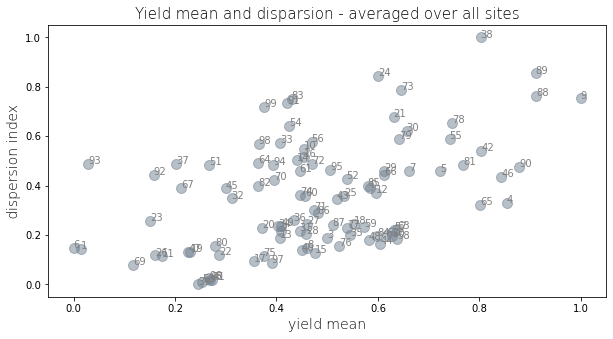

In [4]:
# Standardize yield_mean & yield_disp into between 0 & 1
yield_mean_norm = (
    yield_mean-yield_mean.min())/(yield_mean.max()-yield_mean.min())
yield_disp_norm = (
    yield_disp-yield_disp.min())/(yield_disp.max()-yield_disp.min())

# visulization
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
sc = ax.scatter(yield_mean_norm, yield_disp_norm, c='slategrey', s=100, alpha=0.5)
for i in np.arange(100):
    ax.annotate(i, (yield_mean_norm[i], yield_disp_norm[i]), c='grey')
    
ax.set_xlabel('yield mean', fontweight='light', size=14)
ax.set_ylabel('dispersion index', fontweight='light', size=14)
ax.set_title('Yield mean and disparsion - averaged over all sites', 
             fontweight='light', size=15)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_yield_disp_standardize.png', format='png', dpi=800)

### Parameter values ordered by yield

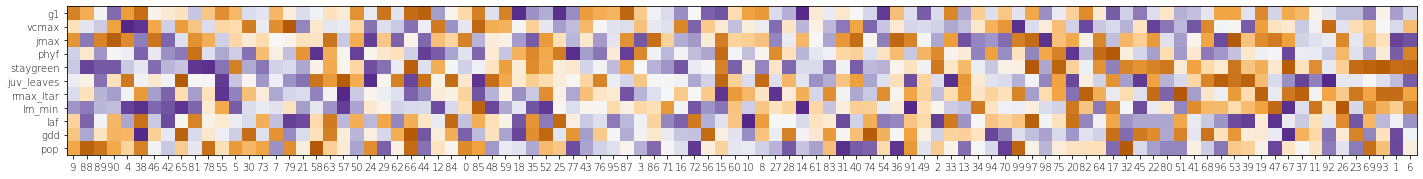

In [5]:
# Order phenotypes based on overall yield performance
df = df_matured
groups = ['cvar', 'site']
mx_mean = agg_sims(df, groups, 'mean', 'dm_ear')
df_yield_means = pd.DataFrame(mx_mean)
df_yield_means['mean'] = df_yield_means.mean(axis=1)
index_sortbymean = df_yield_means.sort_values(by=['mean'], axis=0, ascending=False).index
pheno_order_by_yield = df_yield_means.reindex(index_sortbymean).index.tolist()

# Determined parameters perturbed and perturb range
problem, param_values = params_sample('present', 10)
param_range = dict(zip(problem['names'], problem['bounds']))
params = problem['names']
df_params_fold = pd.DataFrame(columns=params)

# Normalize parameter values
df_params_ordered = df_params.iloc[pheno_order_by_yield, :-1]
for param in params:
    df_params_fold[param] = fold(df_params_ordered[param],
                                 param_range[param][0],
                                 param_range[param][1])

# Visualize
fig, ax = plt.subplots(figsize=(25,6))
im = ax.imshow(df_params_fold.transpose(), cmap=PuOr_7.mpl_colormap)
ax.set_xticks(np.arange(df_params_ordered.shape[0]))
ax.set_yticks(np.arange(df_params_ordered.shape[1]))
ax.set_xticklabels(list(df_params_ordered.index), size=10, fontweight='light')
ax.set_yticklabels(list(df_params_ordered.columns), size=10, fontweight='light')
fig.subplots_adjust(left=0.15)

### Identify top performing trait-management combinations
TODO: Neeed to think more carefully about how ranking is done
- Currently, the top performers are also the ones that perform uniformally well across sites
- Which also probably means they have less of a resposne to climate variability across sites
- How to rank all phenotypes but only rank to, say, top 10?

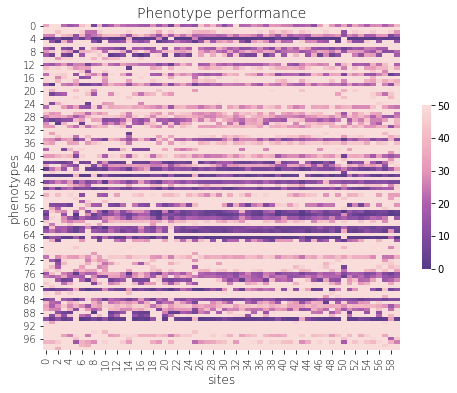

In [9]:
# Function parameters
run_name = 'present'
n_pheno=100
w_yield=1
w_disp=1

# Rank all phenotypes
df_rankings, phenos_ranked = rank_all_phenos(run_name, n_pheno, w_yield, w_disp)

# Visualization
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
im = sns.heatmap(df_rankings,
                 cmap=PurpOr_6.mpl_colormap.reversed(), 
                 vmin=0, vmax=50,
                 cbar_kws={'shrink': 0.5})

ax.set_title('Phenotype performance', fontweight='light', size=14)
ax.set_xlabel('sites', fontweight='light', size=12)
ax.set_ylabel('phenotypes', fontweight='light', size=12)
plt.xticks(fontweight='light', fontsize=10)
plt.yticks(fontweight='light', fontsize=10, rotation=0)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_pheno_performance.png', format='png', dpi=800)

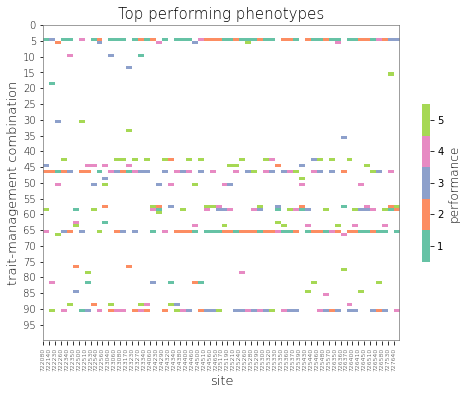

In [8]:
# Identify sites and phenotypes
sites = sorted(list(set(df_all.site)))
phenos = list(set(df_all.cvar))

# Parameters for identify_top_phenos
n_pheno = 5
w_yield = 1
w_disp = 1

# Identify top phenos
df_pheno, mx = identify_top_phenos('present', n_pheno=n_pheno, w_yield=w_yield, w_disp=w_disp)

# Visualization
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
cmap = sns.color_palette('Set2', n_pheno) 
hmap = sns.heatmap(mx, cmap=cmap, cbar_kws={'shrink': 0.5},)
hmap.axhline(y = 0, color='grey',linewidth=1.5)
hmap.axhline(y = mx.shape[0], color='grey', linewidth=1.5)
hmap.axvline(x = 0, color='grey', linewidth=1.5)
hmap.axvline(x = mx.shape[1], color='grey', linewidth=1.5)

colorbar = ax.collections[0].colorbar 
c_range = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + c_range / n_pheno * (0.5 + item) for item in range(n_pheno)])
colorbar.set_ticklabels(['1','2','3','4','5'])    

ax.set_title('Top performing phenotypes', fontweight='light', size=15)
ax.set_xlabel('site', fontweight='light', size=13)
ax.set_ylabel('trait-management combination', fontweight='light', size=13)
ax.figure.axes[-1].set_ylabel('performance', size=12, fontweight='light')

plt.xticks(np.arange(len(sites)))
plt.yticks(np.arange(0, len(phenos), 5))
ax.set_xticklabels(sites, fontsize=6, fontweight='light', rotation=90)
ax.set_yticklabels(np.arange(0, len(phenos), 5), fontsize=10, fontweight='light', rotation=0)

fig.subplots_adjust(bottom=0.15)
#plt.savefig(f'/home/disk/eos8/ach315/upscale/figs/heatmap_topchoice_yield{w_yield}_disp{w_disp}.png', format='png', dpi=800)

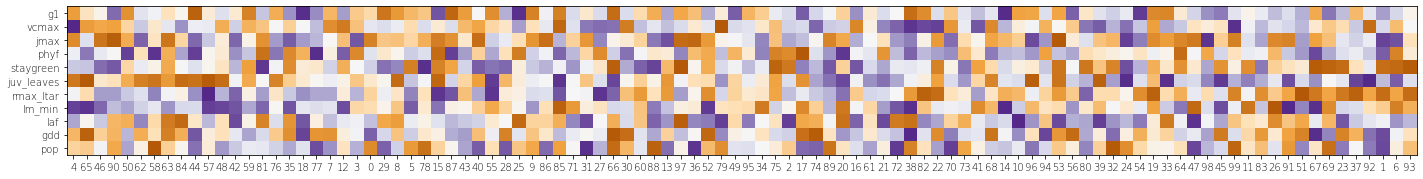

In [12]:
# Order phenotypes based on overall yield performance
df = df_matured
groups = ['cvar', 'site']
mx_mean = agg_sims(df, groups, 'mean', 'dm_ear')
df_yield_means = pd.DataFrame(mx_mean)
df_yield_means['mean'] = df_yield_means.mean(axis=1)
index_sortbymean = df_yield_means.sort_values(by=['mean'], axis=0, ascending=False).index
pheno_order_by_rank = df_yield_means.reindex(phenos_ranked).index.tolist()

# Determined parameters perturbed and perturb range
problem, param_values = params_sample('present', 10)
param_range = dict(zip(problem['names'], problem['bounds']))
params = problem['names']
df_params_fold = pd.DataFrame(columns=params)

# Normalize parameter values
df_params_ordered = df_params.iloc[pheno_order_by_rank, :-1]
for param in params:
    df_params_fold[param] = fold(df_params_ordered[param],
                                 param_range[param][0],
                                 param_range[param][1])

# Visualize
fig, ax = plt.subplots(figsize=(25,6))
im = ax.imshow(df_params_fold.transpose(), cmap=PuOr_7.mpl_colormap)
ax.set_xticks(np.arange(df_params_ordered.shape[0]))
ax.set_yticks(np.arange(df_params_ordered.shape[1]))
ax.set_xticklabels(list(df_params_ordered.index), size=10, fontweight='light')
ax.set_yticklabels(list(df_params_ordered.columns), size=10, fontweight='light')
fig.subplots_adjust(left=0.15)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_param_values_all.png', format='png', dpi=800)

### Identify performance with different weights on dispersion vs. yield

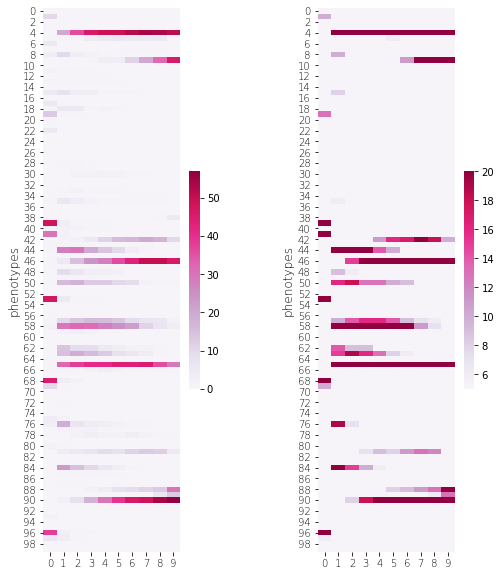

In [403]:
n_pheno = 5
intervals = 10
site_threshold_min = 5
site_threshold_max = 20

# Identify phenotype prevalence
df_pheno_prevalence = top_pheno_prevalence('present', n_pheno, intervals)

# Unscaled colormap
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(1,2,1)
mp1 = sns.heatmap(df_pheno_prevalence, 
                  cmap=PuRd_8.mpl_colormap, vmin=0,
                  cbar_kws={'shrink': 0.4})

ax1.set_ylabel('phenotypes', fontweight='light', size=12)
plt.xticks(fontweight='light', fontsize=10)
plt.yticks(fontweight='light', fontsize=10, rotation=0)

# Scaled colormap
ax2 = fig.add_subplot(1,2,2)
mp2 = sns.heatmap(df_pheno_prevalence, 
                  cmap=PuRd_8.mpl_colormap, 
                  vmax=site_threshold_max, vmin=site_threshold_min,
                  cbar_kws={'shrink': 0.4})
ax2.set_ylabel('phenotypes', fontweight='light', size=12)
plt.xticks(fontweight='light', fontsize=10)
plt.yticks(fontweight='light', fontsize=10, rotation=0)

fig.subplots_adjust(wspace=0.6)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/toppheno_prevalence.png', format='png', dpi=800)

### Param values for high performing phenotypes
Prevelance of being in the top n rankings across sites

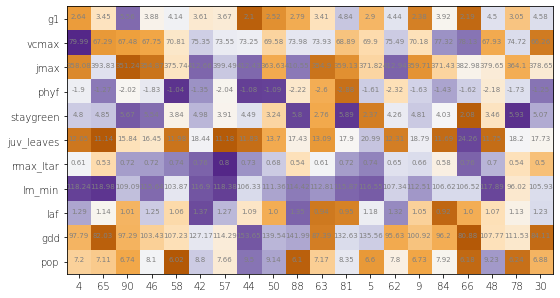

In [404]:
# Parameters for identify_top_phenos
n_pheno = 5
n_phenos_toplot = 20
w_yield = 1
w_disp = 1

# Identify top phenos
df_pheno, mx = identify_top_phenos('present', n_pheno=n_pheno, w_yield=w_yield, w_disp=w_disp)

# Determine high-performing phenotypes
list_top_pheno = []
for item in np.arange(n_pheno):
    top_pheno = list(set(df_pheno.iloc[:,item]))
    list_top_pheno.extend(top_pheno)
list_top_pheno = list(set(list_top_pheno))

# Determine prevalence of phenotype occurrence
df_pheno_count = pd.DataFrame(list(pd.DataFrame(mx).count(axis=1)), columns=['count'])
top_pheno_sorted = list(df_pheno_count.iloc[list_top_pheno].sort_values('count', ascending=False).index)    

# Determined parameters perturbed and perturb range
problem, param_values = params_sample('present', 10)
param_range = dict(zip(problem['names'], problem['bounds']))
params = problem['names']
df_params_fold = pd.DataFrame(columns=params)

# Normalize parameter values
df_highperformance = df_params.iloc[top_pheno_sorted[:n_phenos_toplot], :-1]
for param in params:
    df_params_fold[param] = fold(df_highperformance[param],
                                 param_range[param][0],
                                 param_range[param][1])
    
# Visualize
fig, ax = plt.subplots(figsize=(9,6))

im = ax.imshow(df_params_fold.transpose(), cmap=PuOr_7.mpl_colormap)
ax.set_xticks(np.arange(df_highperformance.shape[0]))
ax.set_yticks(np.arange(df_highperformance.shape[1]))
ax.set_xticklabels(list(df_highperformance.index), size=10, fontweight='light')
ax.set_yticklabels(list(df_highperformance.columns), size=10, fontweight='light')

for top_pheno in range(len(top_pheno_sorted[:n_phenos_toplot])):
    for param in range(len(params)):
        text = ax.text(top_pheno, param,
                       df_params.transpose().loc[params[param],top_pheno_sorted[top_pheno]],
                       ha='center', color='grey', size=7)
fig.subplots_adjust(left=0.15)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_param_values_diverge_top5_prevalence.png', format='png', dpi=800)

### Param values for high performing phenotypes
Prevelance and performance based on all rankings across all sites

- Top 20 performers

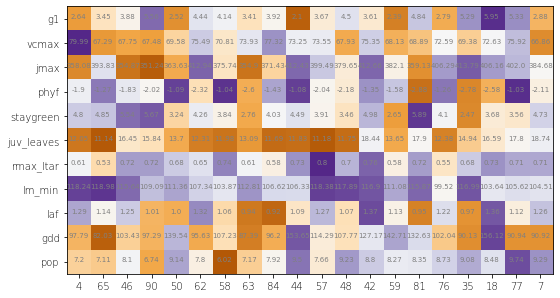

In [405]:
# Rank all phenotypes
n_pheno = 100
w_yield = 1
w_disp = 1
run_name = 'present'
df_rankings, phenos_ranked = rank_all_phenos(run_name, n_pheno, w_yield, w_disp)

# Determined parameters perturbed and perturb range
problem, param_values = params_sample('present', 10)
param_range = dict(zip(problem['names'], problem['bounds']))
params = problem['names']
df_params_fold = pd.DataFrame(columns=params)

# Normalize parameter values
top_phenos = phenos_ranked[:20]
df_highperformance = df_params.iloc[top_phenos, :-1]
for param in params:
    df_params_fold[param] = fold(df_highperformance[param],
                                 param_range[param][0],
                                 param_range[param][1])
    
# Visualize
fig, ax = plt.subplots(figsize=(9,6))
im = ax.imshow(df_params_fold.transpose(), cmap=PuOr_7.mpl_colormap)
ax.set_xticks(np.arange(df_highperformance.shape[0]))
ax.set_yticks(np.arange(df_highperformance.shape[1]))
ax.set_xticklabels(list(df_highperformance.index), size=10, fontweight='light')
ax.set_yticklabels(list(df_highperformance.columns), size=10, fontweight='light')

for top_pheno in range(len(top_phenos)):
    for param in range(len(params)):
        text = ax.text(top_pheno, param,
                       df_params.transpose().loc[params[param],
                                                 top_phenos[top_pheno]],
                       ha='center', color='grey', size=7)
fig.subplots_adjust(left=0.15)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_param_values_diverge.png', format='png', dpi=800)

- Low 20 performers

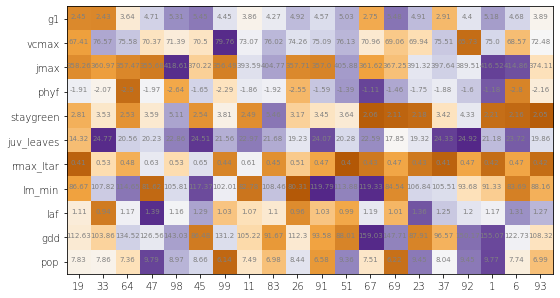

In [406]:
# Rank all phenotypes
n_pheno = 100
w_yield = 1
w_disp = 1
run_name = 'present'
df_rankings, phenos_ranked = rank_all_phenos(run_name, n_pheno, w_yield, w_disp)

# Determined parameters perturbed and perturb range
problem, param_values = params_sample('present', 10)
param_range = dict(zip(problem['names'], problem['bounds']))
params = problem['names']
df_params_fold = pd.DataFrame(columns=params)

# Normalize parameter values
top_phenos = phenos_ranked[80:]
df_highperformance = df_params.iloc[top_phenos, :-1]
for param in params:
    df_params_fold[param] = fold(df_highperformance[param],
                                 param_range[param][0],
                                 param_range[param][1])
    
# Visualize
fig, ax = plt.subplots(figsize=(9,6))
im = ax.imshow(df_params_fold.transpose(), cmap=PuOr_7.mpl_colormap)
ax.set_xticks(np.arange(df_highperformance.shape[0]))
ax.set_yticks(np.arange(df_highperformance.shape[1]))
ax.set_xticklabels(list(df_highperformance.index), size=10, fontweight='light')
ax.set_yticklabels(list(df_highperformance.columns), size=10, fontweight='light')

for top_pheno in range(len(top_phenos)):
    for param in range(len(params)):
        text = ax.text(top_pheno, param,
                       df_params.transpose().loc[params[param],
                                                 top_phenos[top_pheno]],
                       ha='center', color='grey', size=7)
fig.subplots_adjust(left=0.15)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_param_values_diverge.png', format='png', dpi=800)

### Identify performance frontiers

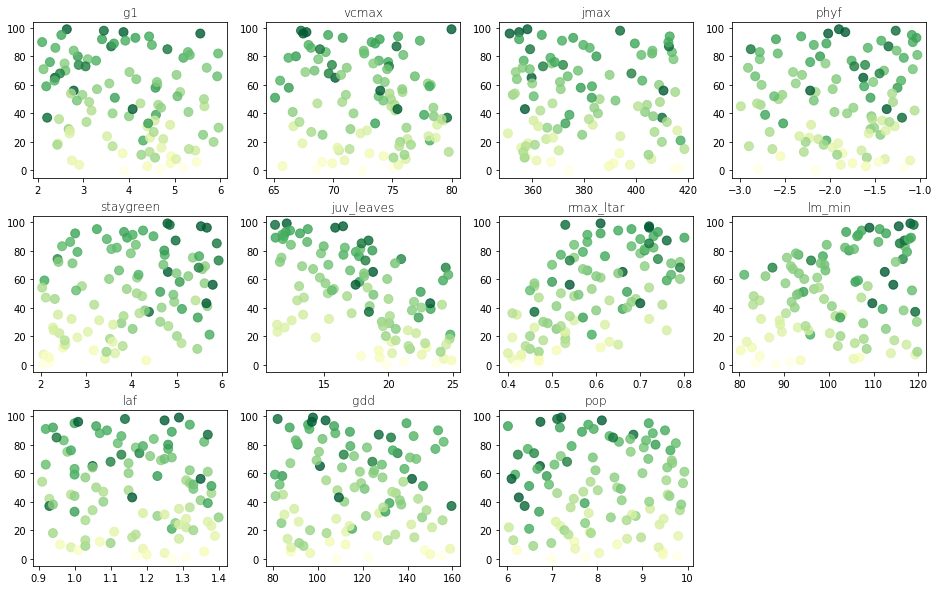

In [409]:
# Function parameters
n_pheno = 100
w_yield = 1
w_disp = 1
run_name = 'present'

# Rank phenotypes
df_rankings, phenos_ranked = rank_all_phenos(run_name, n_pheno, w_yield, w_disp)

# Reverse ranking system
# such that high performance has high rank
phenos_ranked_reversed = phenos_ranked.copy()
phenos_ranked_reversed.reverse()

df_phenorank = pd.DataFrame({'rank': np.arange(100), 
                             'pheno': phenos_ranked_reversed})
phenos_rank_sorted = list(df_phenorank.sort_values('pheno')['rank'])

params = ['g1', 'vcmax', 'jmax', 'phyf',
          'staygreen', 'juv_leaves', 'rmax_ltar', 'lm_min',
          'laf', 'gdd', 'pop']

# visualization
fig = plt.figure(figsize=(16,10))
for index, param in zip(np.arange(len(params)), params):
    ax = fig.add_subplot(3,4,index+1)
    yield_mean = df_all.groupby('cvar').mean().dm_ear
    plt.scatter(df_params.iloc[:100][param], phenos_rank_sorted, 
                c=yield_mean, s=80, alpha=0.8, 
                cmap=YlGn_8.mpl_colormap, vmin=50, vmax=200)
    ax.set_title(param, fontweight='light')

fig.subplots_adjust(wspace=0.2, hspace=0.25)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_params_frontier.png', format='png', dpi=800)

### Explore relatilnship between Performance & Climate

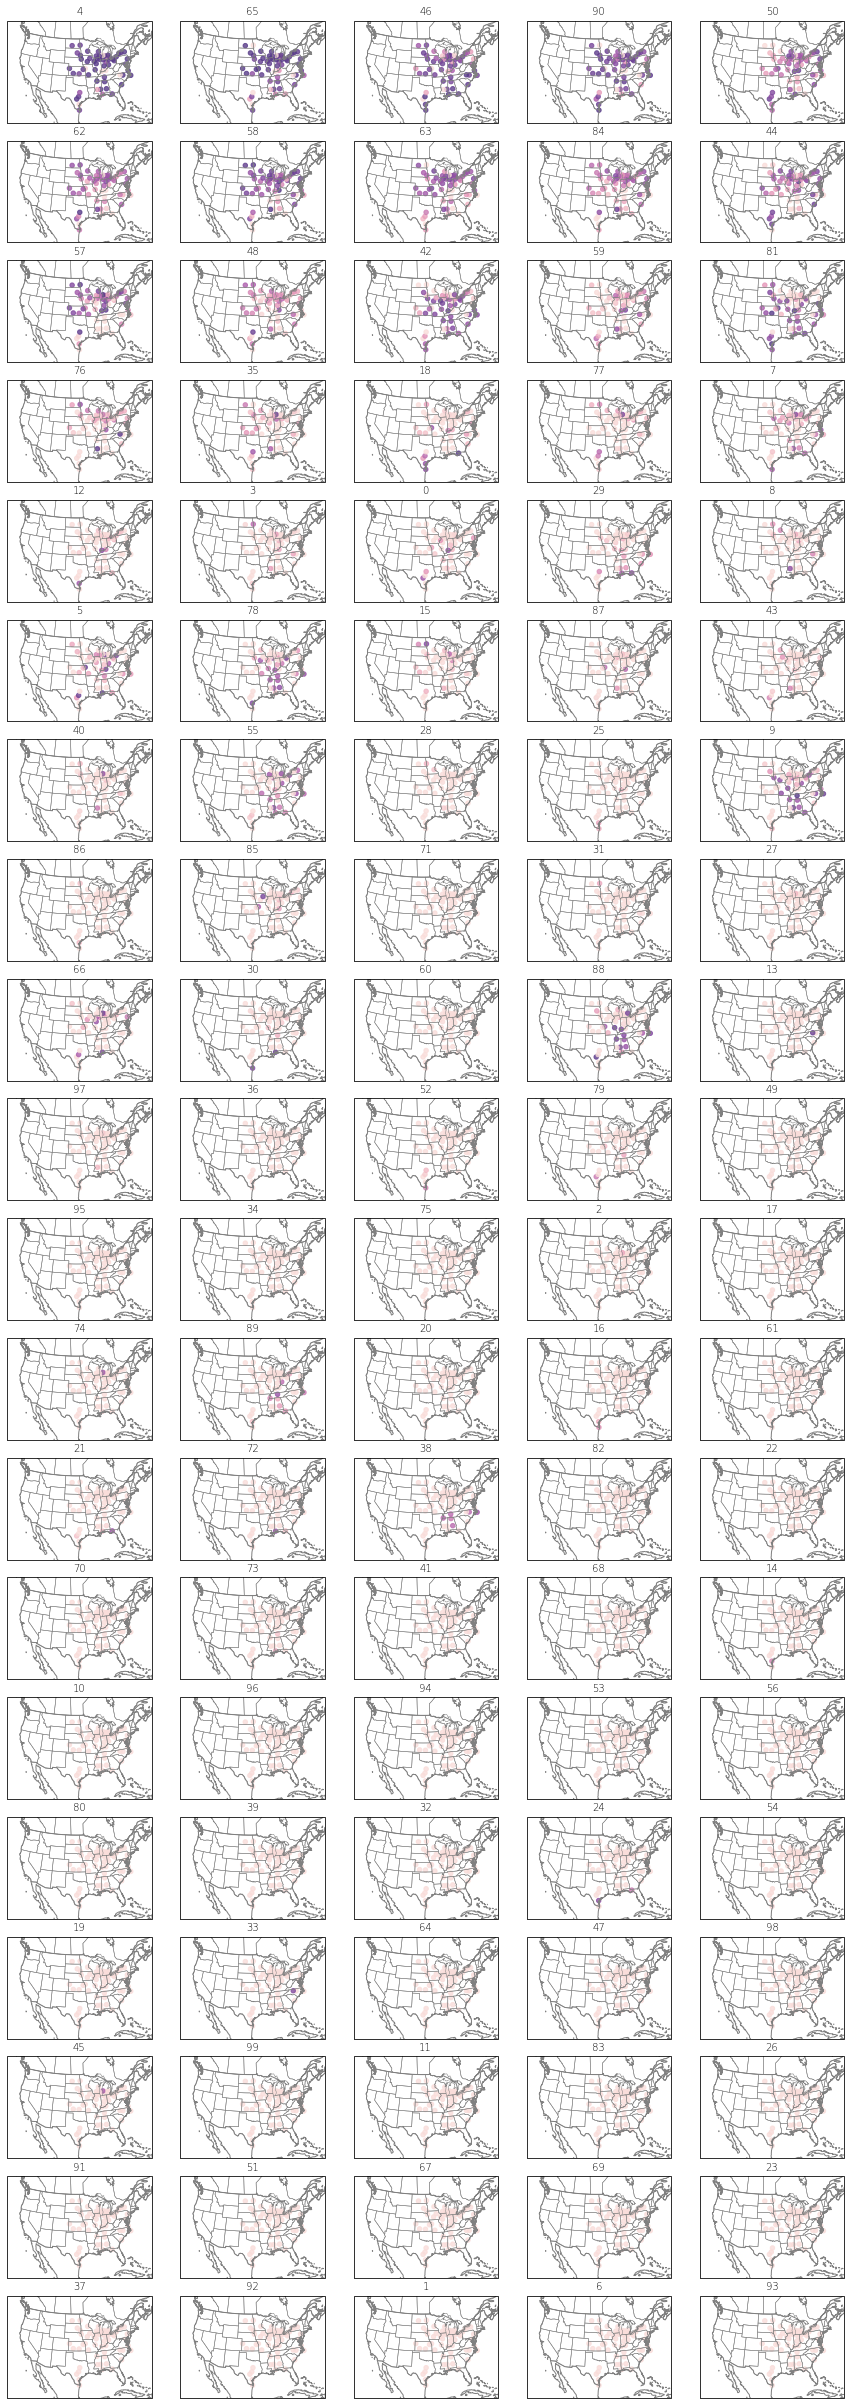

In [50]:
# Visualization
fig = plt.figure(figsize=(15,45))

for item, pheno in enumerate(phenos_ranked[:]):
    ax = fig.add_subplot(20,5,item+1, projection=ccrs.AlbersEqualArea(
        central_latitude=39.5, central_longitude=-98.35))
    ax.set_extent([-123, -72, 19, 53])
    mp = ax.scatter(df_sites.lon, df_sites.lat, transform=ccrs.PlateCarree(),
                    c = df_rankings.iloc[pheno], cmap=PurpOr_6.mpl_colormap.reversed(),
                    vmin=0, vmax=20, alpha=0.8, s=20)
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.set_title(pheno, fontweight='light', size=10)

fig.subplots_adjust(hspace=-0.3)

Rank by prevalence of phenotype to be in top n rank

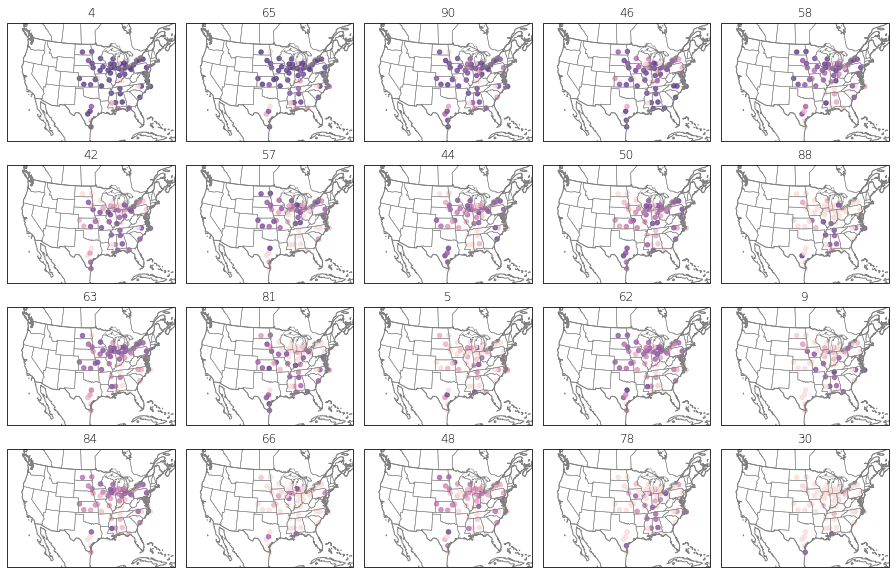

In [328]:
# Parameters for identify_top_phenos
n_pheno = 5
w_yield = 1
w_disp = 1

# Identify top phenos
df_pheno, mx = identify_top_phenos('present', n_pheno=n_pheno, w_yield=w_yield, w_disp=w_disp)

# Determine all of the high-performing phenotypes
# - not ranking any of them yet, just figuring out all the phenotypes
# - that had at least made it into top 5 at at least one location
list_top_pheno = []
for item in np.arange(n_pheno):
    top_pheno = list(set(df_pheno.iloc[:,item]))
    list_top_pheno.extend(top_pheno)
list_top_pheno = list(set(list_top_pheno))

# Determine prevalence of phenotype occurrence
# - performance determined by the counts a specific phenotype makes it
# - as the top n performers
df_pheno_count = pd.DataFrame(list(pd.DataFrame(mx).count(axis=1)), columns=['count'])
top_pheno_sorted = list(df_pheno_count.iloc[list_top_pheno].sort_values('count', ascending=False).index)    

# Visualization
fig = plt.figure(figsize=(16,10))

for item, pheno in enumerate(top_pheno_sorted[:20]):
    ax = fig.add_subplot(4,5,item+1, projection=ccrs.AlbersEqualArea(
        central_latitude=39.5, central_longitude=-98.35))
    ax.set_extent([-123, -72, 19, 53])
    mp = ax.scatter(df_sites.lon, df_sites.lat, transform=ccrs.PlateCarree(),
                    c = df_rankings.iloc[pheno], cmap=PurpOr_6.mpl_colormap.reversed(),
                    vmin=0, vmax=20, alpha=0.8, s=20)
    ax.add_feature(cfeature.BORDERS, edgecolor='grey')
    ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
    ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)
    ax.set_title(pheno, fontweight='light')

fig.subplots_adjust(wspace=0)
    
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/maps_top_pheno_ranking.png', format='png', dpi=800)

### Process climate info

In [103]:
# Overall gseason climate
site_temps = df_all.groupby('site').mean().temp
site_vpds = df_all.groupby('site').mean().vpd
site_precips = df_all.groupby('site').mean().precip

In [140]:
# In-season climate data
df_gseason_climate = pd.read_csv('/home/disk/eos8/ach315/ideotype/ideotype/data/sims/sims_gseason_climate.csv')
df_waterdeficit = pd.read_csv('/home/disk/eos8/ach315/ideotype/ideotype/data/sims/sims_waterdeficit.csv')
df_waterdeficit_sum = pd.read_csv('/home/disk/eos8/ach315/ideotype/ideotype/data/sims/sims_waterdeficit_sum.csv')

In [330]:
df_temp_em, df_vpd_em, df_wd_em = phenostage_climate(df_all, df_gseason_climate, df_waterdeficit, 0)
df_temp_ti, df_vpd_ti, df_wd_ti = phenostage_climate(df_all, df_gseason_climate, df_waterdeficit, 1)
df_temp_ts, df_vpd_ts, df_wd_ts = phenostage_climate(df_all, df_gseason_climate, df_waterdeficit, 2)
df_temp_gf, df_vpd_gf, df_wd_gf = phenostage_cliamte(df_all, df_gseason_climate, df_waterdeficit, 3)

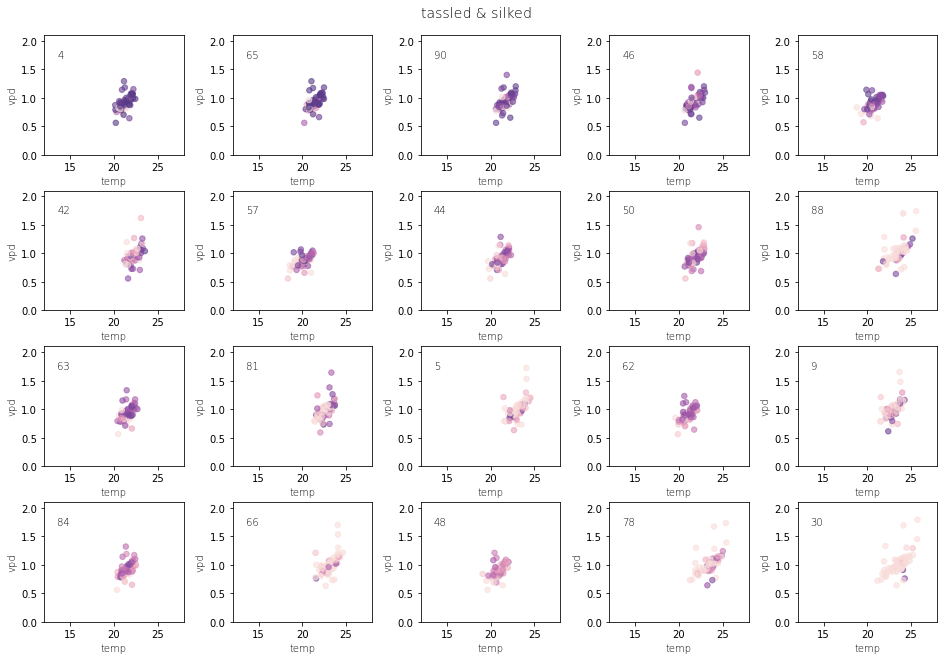

In [308]:
# Visualization
fig = plt.figure(figsize=(16,10))

for item, pheno in enumerate(top_pheno_sorted[:20]):
    ax = fig.add_subplot(4,5,item+1)
    ax.scatter(df_temp_ts.iloc[pheno],
               df_vpd_ts.iloc[pheno],
               c = df_rankings.iloc[pheno], cmap=PurpOr_6.mpl_colormap.reversed(),
               vmin=0, vmax=20, alpha=0.6, s=30)
    ax.set_xlim(12,28)
    ax.set_ylim(0,2.1)
    ax.set_xlabel('temp', fontweight='light')
    ax.set_ylabel('vpd', fontweight='light')
    ax.annotate(pheno, (13.5, 1.7), fontweight='light', size=10)

fig.suptitle('tassled & silked', fontweight='light', size=14)
fig.subplots_adjust(top=0.94, wspace=0.35, hspace=0.3)

plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_performance_temp_vpd_ts.png', format='png', dpi=800)

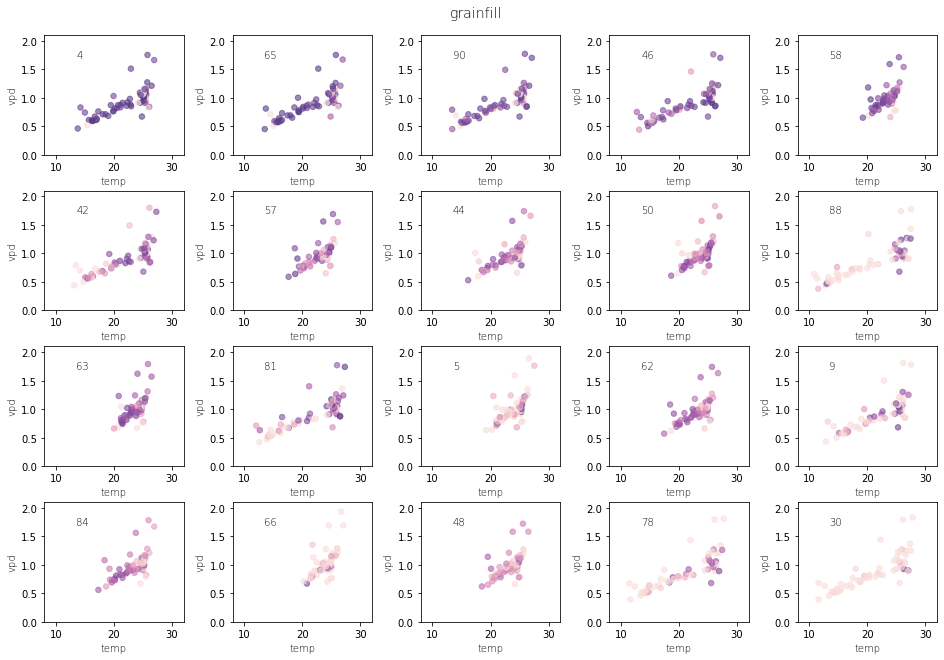

In [309]:
# Visualization
fig = plt.figure(figsize=(16,10))

for item, pheno in enumerate(top_pheno_sorted[:20]):
    ax = fig.add_subplot(4,5,item+1)
    ax.scatter(df_temp_gf.iloc[pheno],
               df_vpd_gf.iloc[pheno],
               c = df_rankings.iloc[pheno], cmap=PurpOr_6.mpl_colormap.reversed(),
               vmin=0, vmax=20, alpha=0.6, s=30)
    ax.set_xlim(8,32)
    ax.set_ylim(0,2.1)
    ax.set_xlabel('temp', fontweight='light')
    ax.set_ylabel('vpd', fontweight='light')
    ax.annotate(pheno, (13.5, 1.7), fontweight='light', size=10)

fig.suptitle('grainfill', fontweight='light', size=14)
fig.subplots_adjust(top=0.94, wspace=0.35, hspace=0.3)

plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_performance_temp_vpd_gf.png', format='png', dpi=800)

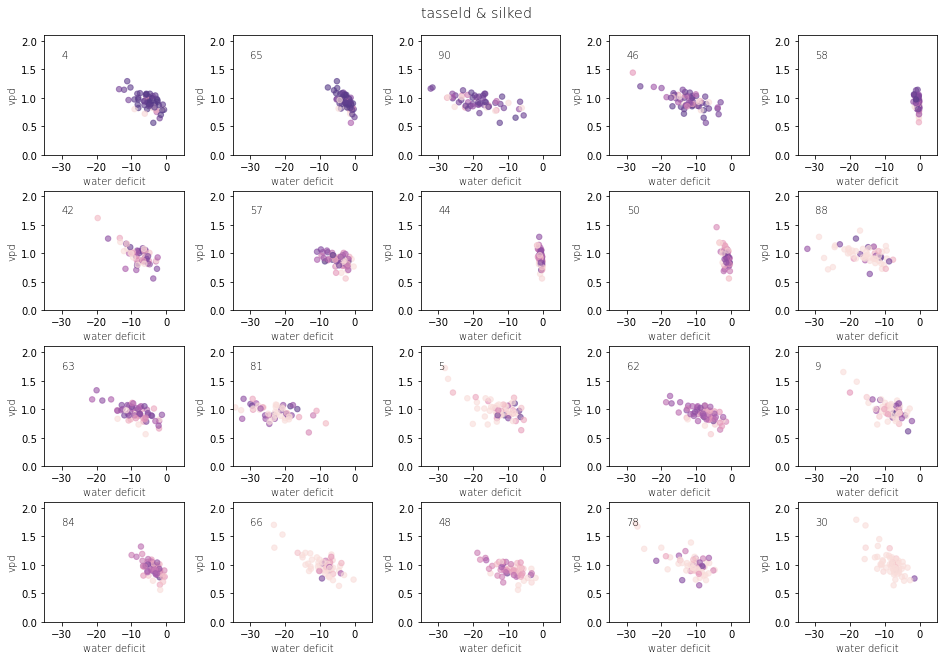

In [310]:
# Visualization
fig = plt.figure(figsize=(16,10))

for item, pheno in enumerate(top_pheno_sorted[:20]):
    ax = fig.add_subplot(4,5,item+1)
    ax.scatter(df_wd_ts.iloc[pheno],
               df_vpd_ts.iloc[pheno],
               c = df_rankings.iloc[pheno], cmap=PurpOr_6.mpl_colormap.reversed(),
               vmin=0, vmax=20, alpha=0.6, s=30)
    ax.set_xlim(-35,5)
    ax.set_ylim(0,2.1)
    ax.set_xlabel('water deficit', fontweight='light')
    ax.set_ylabel('vpd', fontweight='light')
    ax.annotate(pheno, (-30, 1.7), fontweight='light', size=10)

fig.suptitle('tasseld & silked', fontweight='light', size=14)
fig.subplots_adjust(top=0.94, wspace=0.35, hspace=0.3)

plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_performance_wd_vpd_ts.png', format='png', dpi=800)

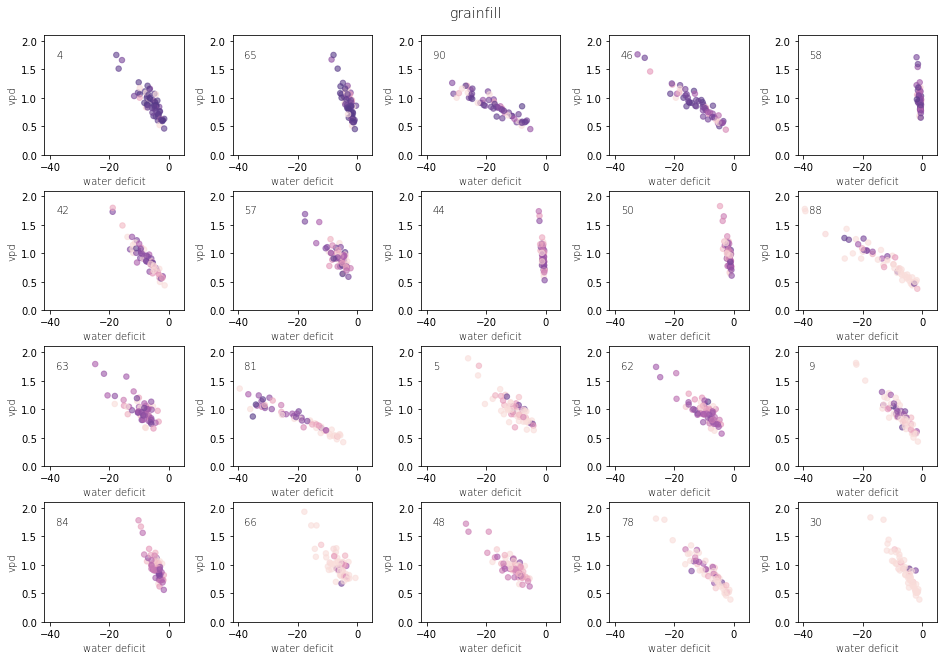

In [311]:
# Visualization
fig = plt.figure(figsize=(16,10))

for item, pheno in enumerate(top_pheno_sorted[:20]):
    ax = fig.add_subplot(4,5,item+1)
    ax.scatter(df_wd_gf.iloc[pheno],
               df_vpd_gf.iloc[pheno],
               c = df_rankings.iloc[pheno], cmap=PurpOr_6.mpl_colormap.reversed(),
               vmin=0, vmax=20, alpha=0.6, s=30)
    ax.set_xlim(-42,5)
    ax.set_ylim(0,2.1)
    ax.set_xlabel('water deficit', fontweight='light')
    ax.set_ylabel('vpd', fontweight='light')
    ax.annotate(pheno, (-38, 1.7), fontweight='light', size=10)

fig.suptitle('grainfill', fontweight='light', size=14)
fig.subplots_adjust(top=0.94, wspace=0.35, hspace=0.3)

plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_performance_wd_vpd_gf.png', format='png', dpi=800)

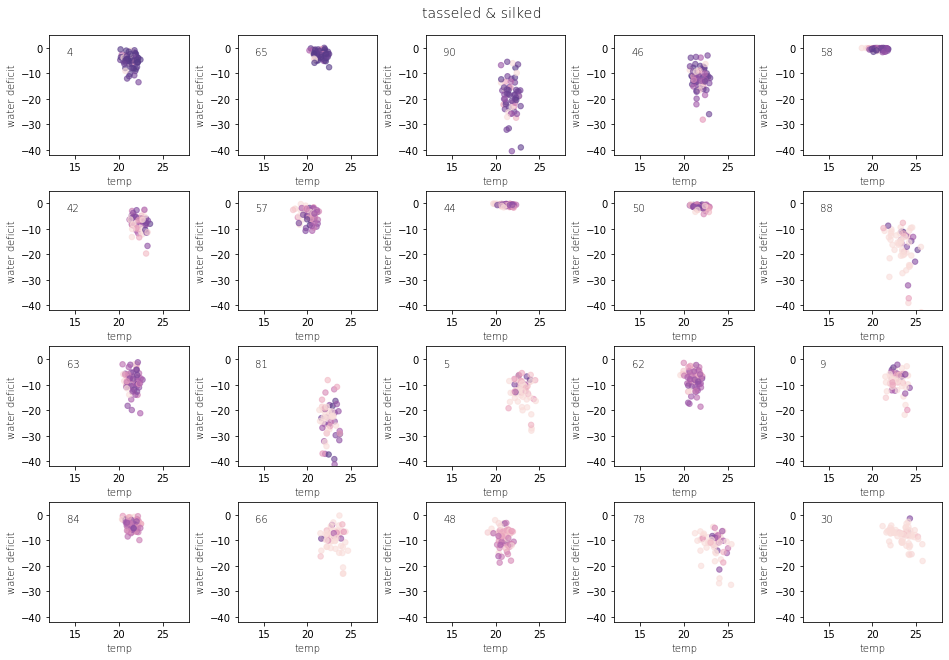

In [322]:
# Visualization
fig = plt.figure(figsize=(16,10))

for item, pheno in enumerate(top_pheno_sorted[:20]):
    ax = fig.add_subplot(4,5,item+1)
    ax.scatter(df_temp_ts.iloc[pheno],
               df_wd_ts.iloc[pheno],
               c = df_rankings.iloc[pheno], cmap=PurpOr_6.mpl_colormap.reversed(),
               vmin=0, vmax=20, alpha=0.6, s=30)
    ax.set_xlim(12,28)
    ax.set_ylim(-42,5)
    ax.set_xlabel('temp', fontweight='light')
    ax.set_ylabel('water deficit', fontweight='light')
    ax.annotate(pheno, (14, -3), fontweight='light', size=10)

fig.suptitle('tasseled & silked', fontweight='light', size=14)
fig.subplots_adjust(top=0.94, wspace=0.35, hspace=0.3)

plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_performance_temp_wd_ts.png', format='png', dpi=800)

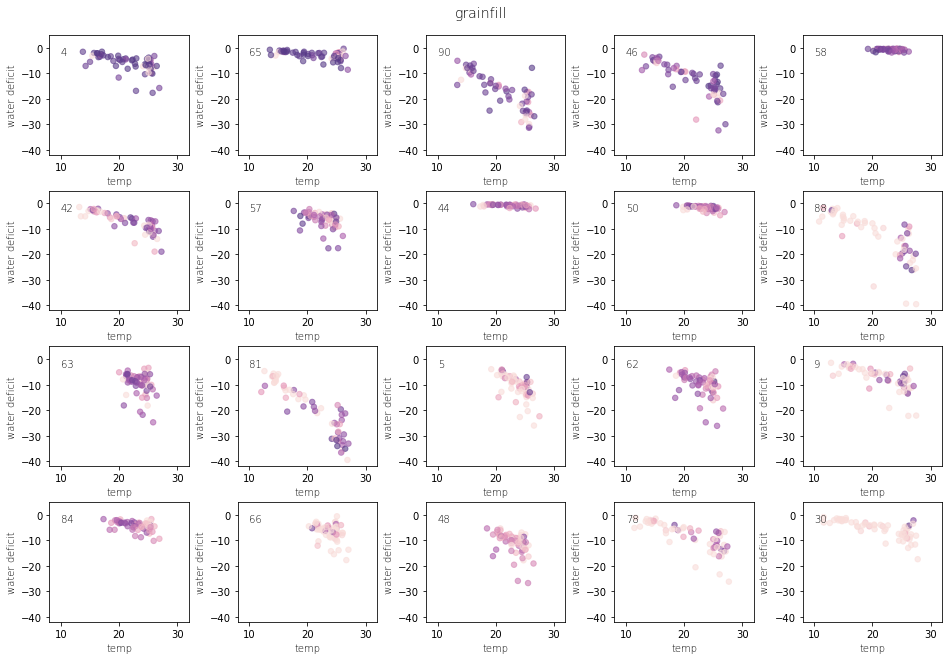

In [293]:
# Visualization
fig = plt.figure(figsize=(16,10))

for item, pheno in enumerate(top_pheno_sorted[:20]):
    ax = fig.add_subplot(4,5,item+1)
    ax.scatter(df_temp_gf.iloc[pheno],
               df_wd_gf.iloc[pheno],
               c = df_rankings.iloc[pheno], cmap=PurpOr_6.mpl_colormap.reversed(),
               vmin=0, vmax=20, alpha=0.6, s=30)
    ax.set_xlim(8,32)
    ax.set_ylim(-42,5)
    ax.set_xlabel('temp', fontweight='light')
    ax.set_ylabel('water deficit', fontweight='light')
    ax.annotate(pheno, (10, -3), fontweight='light', size=10)

fig.suptitle('grainfill', fontweight='light', size=14)
fig.subplots_adjust(top=0.94, wspace=0.35, hspace=0.3)

plt.savefig('/home/disk/eos8/ach315/upscale/figs/scatter_performance_temp_wd_gf.png', format='png', dpi=800)

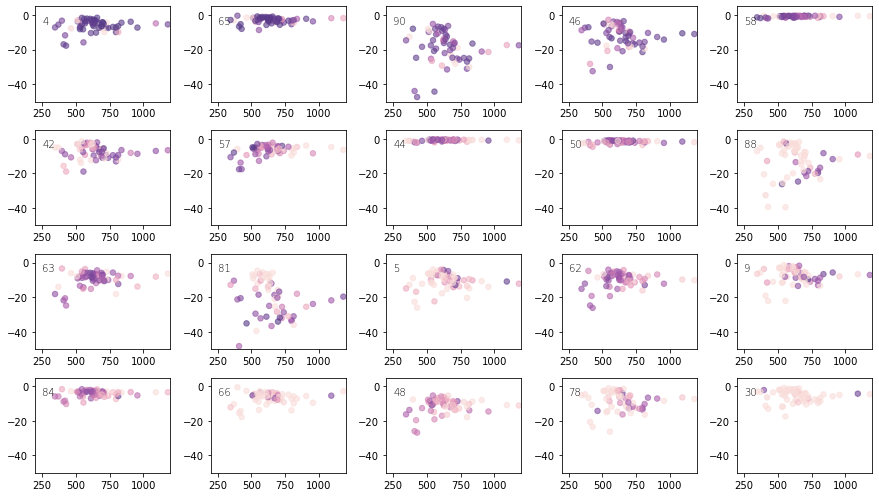

In [194]:
# Visualization
fig = plt.figure(figsize=(15,45))

for item, pheno in enumerate(top_pheno_sorted[:20]):
    ax = fig.add_subplot(20,5,item+1)
    ax.scatter(site_precips,
               df_wd_gf.iloc[pheno],
               c = df_rankings.iloc[pheno], cmap=PurpOr_6.mpl_colormap.reversed(),
               vmin=0, vmax=20, alpha=0.6, s=30)
    ax.set_xlim(200,1200)
    ax.set_ylim(-50,5)
    ax.annotate(pheno, (250, -5), fontweight='light', size=10)

fig.subplots_adjust(wspace=0.3, hspace=0.3)

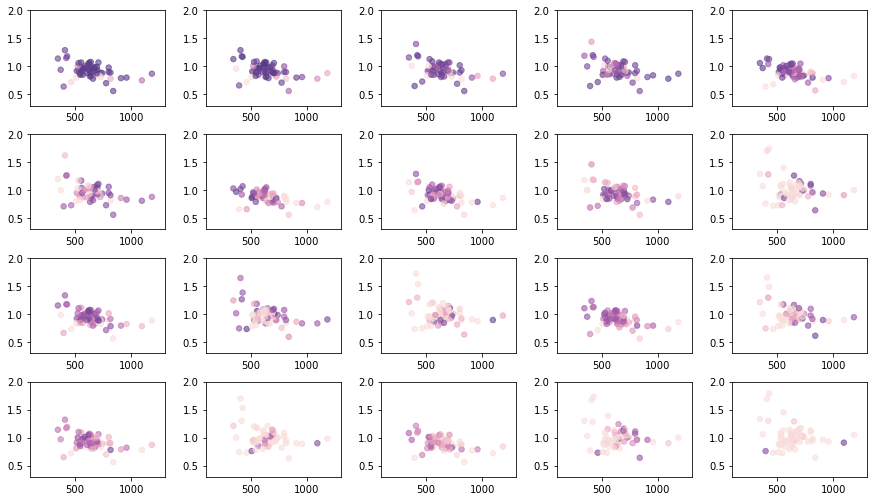

In [319]:
# Visualization
fig = plt.figure(figsize=(15,45))

for item, pheno in enumerate(top_pheno_sorted[:20]):
    ax = fig.add_subplot(20,5,item+1)
    ax.scatter(site_precips,
               df_vpd_ts.iloc[pheno],
               c = df_rankings.iloc[pheno], cmap=PurpOr_6.mpl_colormap.reversed(),
               vmin=0, vmax=20, alpha=0.6, s=30)
    ax.set_xlim(100,1300)
    ax.set_ylim(0.3,2)
    ax.annotate(pheno, (250, -5), fontweight='light', size=10)

fig.subplots_adjust(wspace=0.3, hspace=0.3)

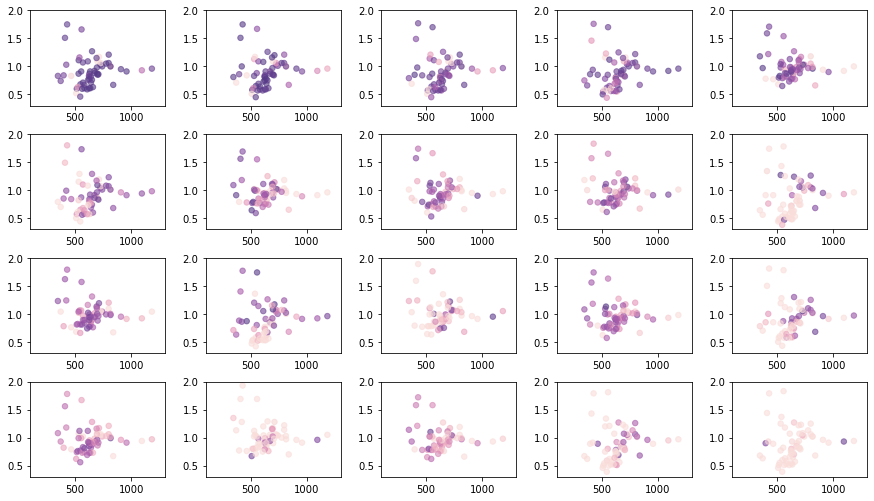

In [218]:
# Visualization
fig = plt.figure(figsize=(15,45))

for item, pheno in enumerate(top_pheno_sorted[:20]):
    ax = fig.add_subplot(20,5,item+1)
    ax.scatter(site_precips,
               df_vpd_gf.iloc[pheno],
               c = df_rankings.iloc[pheno], cmap=PurpOr_6.mpl_colormap.reversed(),
               vmin=0, vmax=20, alpha=0.6, s=30)
    ax.set_xlim(100,1300)
    ax.set_ylim(0.3,2)
    ax.annotate(pheno, (250, -5), fontweight='light', size=10)

fig.subplots_adjust(wspace=0.3, hspace=0.3)

### Explore relationship between Climate & Yield

In [413]:
df_sims.head()

cvar  year    site      pheno   yield    lat    lon soil_texture
0     0  1961  722080  "Matured"  210.24  32.90 -80.03         SaLo
1     0  1961  722140  "Matured"  174.21  30.40 -84.35         LoSa
2     0  1961  722230  "Matured"  200.08  30.68 -88.25         SaLo
3     0  1961  722260  "Matured"  170.33  32.30 -86.40         SaLo
4     0  1961  722340  "Matured"  199.27  32.33 -88.75         SaLo

In [ ]:
# climate
df_tempvpd = df_gseason_climate[['cvar', 'year', 'site', 'pheno', 'temp_air', 'vpd']]
df_all = df_tempvpd.copy()
df_all['wd_sum'] = list(df_waterdeficit_sum['water_deficit_sum'])

# Filter out climate during phenostage
df_em = df_all[df_all['pheno'] == '"Emerged"']
df_em = pd.merge(df_sims, df_em, how='left', on=['cvar', 'year', 'site'])
df_ti = df_all[df_all['pheno'] == '"Tasselinit"']
df_ti = pd.merge(df_sims, df_ti, how='left', on=['cvar', 'year', 'site'])
df_td = df_all[df_all['pheno'] == '"Tasseled"']
df_td = pd.merge(df_sims, df_td, how='left', on=['cvar', 'year', 'site'])
df_sk = df_all[df_all['pheno'] == '"Silked"']
df_sk = pd.merge(df_sims, df_sk, how='left', on=['cvar', 'year', 'site'])
df_gf = df_all[df_all['pheno'] == '"grainFill"']
df_gf = pd.merge(df_sims, df_gf, how='left', on=['cvar', 'year', 'site'])

# construct pandas table to run PCA
df = pd.DataFrame({'cvar': list(df_sims['cvar']),
                   'yield': list(df_sims['yield']),
                   'temp_em': list(df_em['temp_air']),
                   'temp_ti': list(df_ti['temp_air']),
                   'temp_td': list(df_td['temp_air']),
                   'temp_sk': list(df_sk['temp_air']),
                   'temp_gf': list(df_gf['temp_air']),
                   'vpd_em': list(df_em['vpd']),
                   'vpd_ti': list(df_ti['vpd']),
                   'vpd_td': list(df_td['vpd']),
                   'vpd_sk': list(df_sk['vpd']),
                   'vpd_gf': list(df_gf['vpd']),
                   'wd_em': list(df_em['wd_sum']),
                   'wd_ti': list(df_ti['wd_sum']),
                   'wd_td': list(df_td['wd_sum']),
                   'wd_sk': list(df_sk['wd_sum']),
                   'wd_gf': list(df_gf['wd_sum'])})

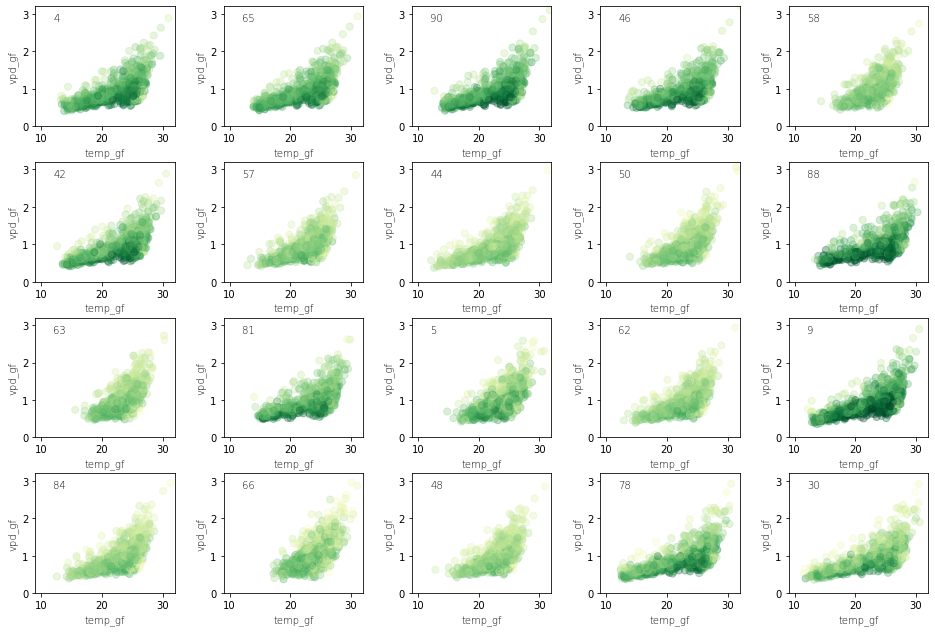

In [370]:
x = 'temp_gf'
y = 'vpd_gf'

fig = plt.figure(figsize=(16,10))

for item, top_pheno in enumerate(top_pheno_sorted[:20]):
    # top pheno
    pheno_num = top_pheno
        
    # sims
    df_phenos_sub = df.query(f'cvar=={pheno_num}')

    # visualizing pca output
    ax = fig.add_subplot(4,5,item+1)
    ax.scatter(df_phenos_sub[x],
               df_phenos_sub[y],
               c=df_phenos_sub['yield'],
               s=50, alpha=0.3, cmap=YlGn_9.mpl_colormap,
               vmin=50, vmax=300)

    ax.set_xlabel(x, fontsize = 10, fontweight='light')
    ax.set_ylabel(y, fontsize = 10, fontweight='light')
    ax.set_xlim(9, 32)
    ax.set_ylim(0, 3.2)
    ax.annotate(top_pheno, (12,2.8), fontweight='light', size=10)

fig.subplots_adjust(top=0.94, wspace=0.35, hspace=0.3)

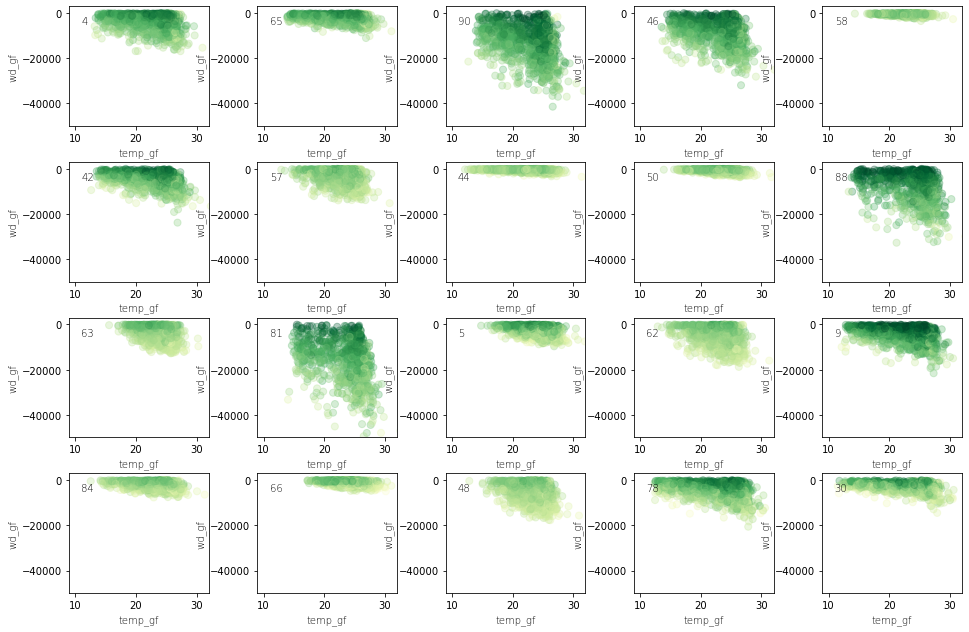

In [388]:
x = 'temp_gf'
y = 'wd_gf'

fig = plt.figure(figsize=(16,10))

for item, top_pheno in enumerate(top_pheno_sorted[:20]):
    # top pheno
    pheno_num = top_pheno
        
    # sims
    df_phenos_sub = df.query(f'cvar=={pheno_num}')

    # visualizing pca output
    ax = fig.add_subplot(4,5,item+1)
    ax.scatter(df_phenos_sub[x],
               df_phenos_sub[y],
               c=df_phenos_sub['yield'],
               s=50, alpha=0.3, cmap=YlGn_9.mpl_colormap,
               vmin=50, vmax=300)

    ax.set_xlabel(x, fontsize = 10, fontweight='light')
    ax.set_ylabel(y, fontsize = 10, fontweight='light')
    ax.set_xlim(9, 32)
    ax.set_ylim(-50000, 3000)
    ax.annotate(top_pheno, (11,-5000), fontweight='light', size=10)

fig.subplots_adjust(top=0.94, wspace=0.35, hspace=0.3)

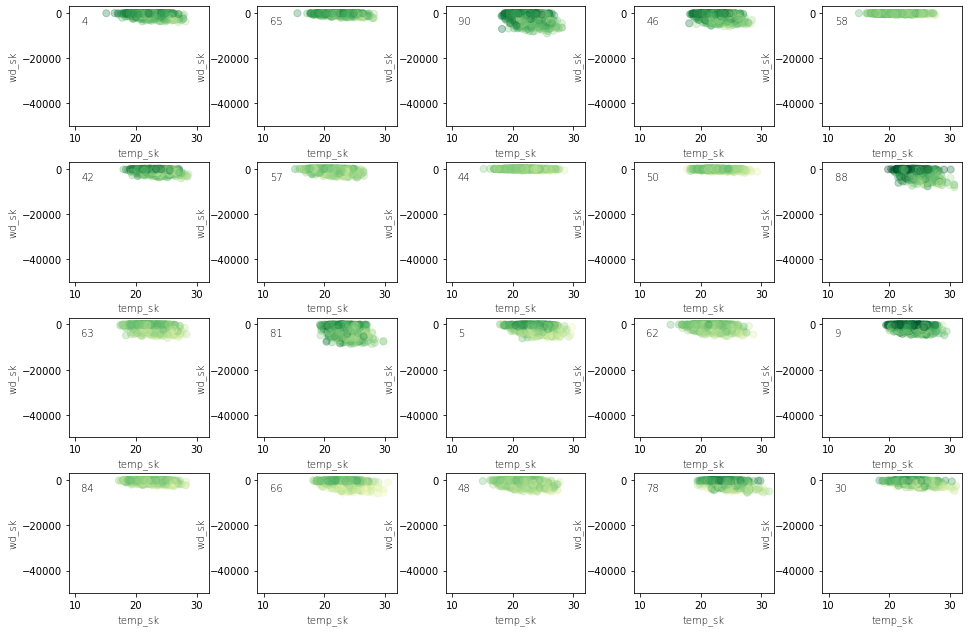

In [392]:
x = 'temp_sk'
y = 'wd_sk'

fig = plt.figure(figsize=(16,10))

for item, top_pheno in enumerate(top_pheno_sorted[:20]):
    # top pheno
    pheno_num = top_pheno
        
    # sims
    df_phenos_sub = df.query(f'cvar=={pheno_num}')

    # visualizing pca output
    ax = fig.add_subplot(4,5,item+1)
    ax.scatter(df_phenos_sub[x],
               df_phenos_sub[y],
               c=df_phenos_sub['yield'],
               s=50, alpha=0.3, cmap=YlGn_9.mpl_colormap,
               vmin=50, vmax=300)

    ax.set_xlabel(x, fontsize = 10, fontweight='light')
    ax.set_ylabel(y, fontsize = 10, fontweight='light')
    ax.set_xlim(9, 32)
    ax.set_ylim(-50000, 3000)
    ax.annotate(top_pheno, (11,-5000), fontweight='light', size=10)

fig.subplots_adjust(top=0.94, wspace=0.35, hspace=0.3)

### Mean yield impact from top 5 high-yielding phenotype for each site
Average positive yield impact from adopting the top 5 identified phenotypes for each location

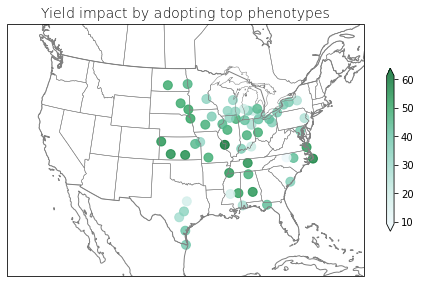

In [20]:
# Read in sims from control runs
df_sims_control, df_sites_control, df_wea_control, df_params_control, df_all_control, df_matured_control = read_data(
    '/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths_control_dympd.yml')

# Calculate mean yield for each site
default_pheno_yields = list(df_matured_control.groupby('site').mean().dm_ear)

# Identify top phenotypes for each site
top_phenos_yields = []
for item, site in enumerate(sites):
    df_site_phenos = pd.DataFrame(mx).iloc[:,item]
    phenos = list(df_site_phenos[df_site_phenos.notnull()].index.values)
    top_phenos_yield = df_matured[
        (df_matured.cvar.isin(phenos)) & (df_matured.site == site)].dm_ear.mean().round(2)
    top_phenos_yields.append(top_phenos_yield)

# Calculate yield impact by adopting top phenotype for each site
yield_impacts = []
for count, site in enumerate(sites):
    yield_impact = ((top_phenos_yields[count]-default_pheno_yields[count])/default_pheno_yields[count])*100
    yield_impacts.append(yield_impact)

# Visualization
fig = plt.figure(figsize=(8,6))
extent = [-123, -72, 19, 53]

ax = fig.add_subplot(1,1,1, projection=ccrs.AlbersEqualArea(
    central_latitude=39.5, central_longitude=-98.35))

ax.set_extent(extent)
mp = ax.scatter(df_sites.lon, df_sites.lat, transform = ccrs.PlateCarree(),
                c=yield_impacts, cmap=BuGn_6.mpl_colormap, s=80, alpha=0.8)
#                vmin=30, vmax=50)
ax.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax.add_feature(cfeature.BORDERS, edgecolor='grey')
ax.add_feature(cfeature.STATES, edgecolor='grey', linewidth=0.5)

ax.set_title('Yield impact by adopting top phenotypes', fontweight='light', fontsize=14)
fig.colorbar(mp, shrink=0.5, extend='both')

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/yield_impact_map.png', format='png', dpi=800)